## DenseNet-121

In [2]:
import numpy as np
import pickle
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import preprocess_input

In [3]:
# Path to your local CIFAR-100 folder
base_path = 'cifar-100-python'

# Helper function to load CIFAR-100 batch (train/test)
def load_cifar100_batch(file_name):
    with open(os.path.join(base_path, file_name), 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    return data['data'], data['fine_labels']

In [4]:
# Load the train and test data
x_train, y_train = load_cifar100_batch('train')
x_test, y_test = load_cifar100_batch('test')

In [5]:
# Reshape and transpose data (N, 32, 32, 3)
x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

In [6]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

In [7]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image, label

# Convert data to TensorFlow datasets first (no resize yet)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply resizing and preprocessing lazily
batch_size = 128
train_dataset = train_dataset.map(preprocess_image).shuffle(50000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [8]:
print("✅ Loaded CIFAR-100 and ready for DenseNet121 training!")


✅ Loaded CIFAR-100 and ready for DenseNet121 training!


In [9]:
import pickle
import os

# Path to your local CIFAR-100 folder
base_path = 'cifar-100-python'  

# Helper function to load CIFAR-100 meta file (for fine labels)
def load_cifar100_meta():
    with open(os.path.join(base_path, 'meta'), 'rb') as file:
        meta = pickle.load(file, encoding='latin1')
    return meta['fine_label_names']

# Load the fine label names
fine_labels = load_cifar100_meta()

# Print all fine labels (categories)
print(f"Total labels: {len(fine_labels)}")
for i, label in enumerate(fine_labels):
    print(f"{i}: {label}")


Total labels: 100
0: apple
1: aquarium_fish
2: baby
3: bear
4: beaver
5: bed
6: bee
7: beetle
8: bicycle
9: bottle
10: bowl
11: boy
12: bridge
13: bus
14: butterfly
15: camel
16: can
17: castle
18: caterpillar
19: cattle
20: chair
21: chimpanzee
22: clock
23: cloud
24: cockroach
25: couch
26: crab
27: crocodile
28: cup
29: dinosaur
30: dolphin
31: elephant
32: flatfish
33: forest
34: fox
35: girl
36: hamster
37: house
38: kangaroo
39: keyboard
40: lamp
41: lawn_mower
42: leopard
43: lion
44: lizard
45: lobster
46: man
47: maple_tree
48: motorcycle
49: mountain
50: mouse
51: mushroom
52: oak_tree
53: orange
54: orchid
55: otter
56: palm_tree
57: pear
58: pickup_truck
59: pine_tree
60: plain
61: plate
62: poppy
63: porcupine
64: possum
65: rabbit
66: raccoon
67: ray
68: road
69: rocket
70: rose
71: sea
72: seal
73: shark
74: shrew
75: skunk
76: skyscraper
77: snail
78: snake
79: spider
80: squirrel
81: streetcar
82: sunflower
83: sweet_pepper
84: table
85: tank
86: telephone
87: televisi

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.densenet import DenseNet121

# Build the DenseNet121 model
densenet_model = Sequential()

# Load DenseNet121 pre-trained model
pretrained_model = DenseNet121(
    include_top=False,
    input_shape=(224, 224, 3),  # Note: DenseNet121 expects 224x224 images
    pooling='avg',
    weights='imagenet'
)

# Freeze the layers of DenseNet121 to prevent training
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained model to the custom model
densenet_model.add(pretrained_model)
densenet_model.add(Flatten())
densenet_model.add(Dense(512, activation='relu'))
densenet_model.add(Dense(100, activation='softmax'))  # CIFAR-100 has 100 classes

# Compile the model
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
densenet_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,613,604 (29.04 MB)

 Trainable params: 576,100 (2.20 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [11]:
epochs=5
history = densenet_model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs
)

Epoch 1/5


2025-04-23 12:48:20.988283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 21412 of 50000
2025-04-23 12:48:31.044005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 34161 of 50000
2025-04-23 12:48:43.360130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 2228s 6s/step - accuracy: 0.4509 - loss: 2.2404 - val_accuracy: 0.6490 - val_loss: 1.1874
Epoch 2/5


2025-04-23 13:25:25.990373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 21470 of 50000
2025-04-23 13:25:36.038669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 35287 of 50000
2025-04-23 13:25:46.105127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 48993 of 50000
2025-04-23 13:25:46.553487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 2149s 5s/step - accuracy: 0.6948 - loss: 1.0437 - val_accuracy: 0.6731 - val_loss: 1.1069
Epoch 3/5


2025-04-23 14:01:15.569938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 19815 of 50000
2025-04-23 14:01:33.306623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 2001s 5s/step - accuracy: 0.7378 - loss: 0.8819 - val_accuracy: 0.6847 - val_loss: 1.0755
Epoch 4/5


2025-04-23 14:34:36.190897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 18308 of 50000
2025-04-23 14:34:46.268490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 31761 of 50000
2025-04-23 14:34:57.487204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 2060s 5s/step - accuracy: 0.7631 - loss: 0.7872 - val_accuracy: 0.6945 - val_loss: 1.0575
Epoch 5/5


2025-04-23 15:08:56.598444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 19313 of 50000
2025-04-23 15:09:16.359243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 49363 of 50000
2025-04-23 15:09:16.703229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 2144s 5s/step - accuracy: 0.7829 - loss: 0.7185 - val_accuracy: 0.6967 - val_loss: 1.0541


In [25]:
densenet_model.save('densenet_cifar100_model.keras')


In [27]:
# Load the saved model
loaded_model = tf.keras.models.load_model('densenet_cifar100_model.keras')



In [29]:
import matplotlib.pyplot as plt

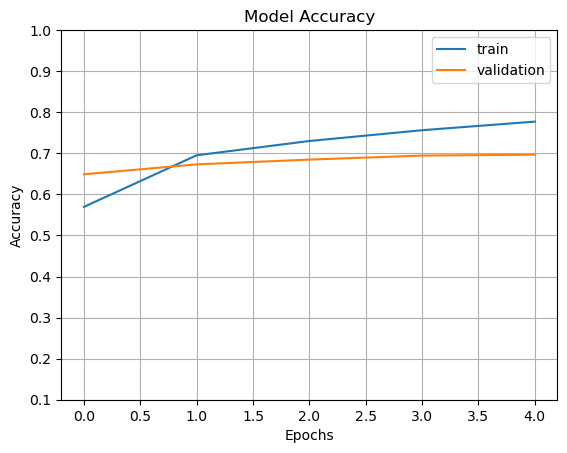

In [31]:
#Evaluating The Model
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

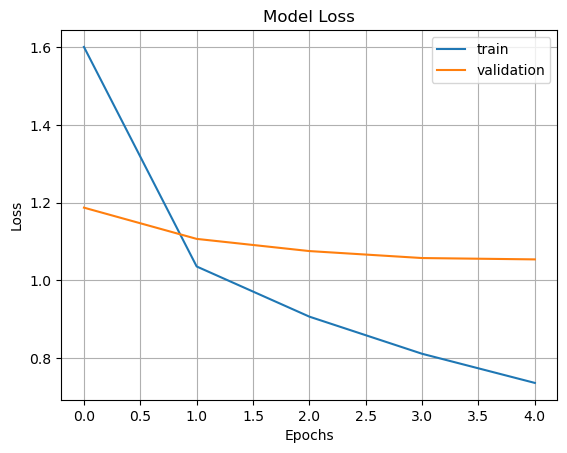

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()